In [1]:
!ls '/content/drive/MyDrive/Team-Fermata-Energy/[EXTERNAL] breakthrough_tech_ai_f24/data'

ls: cannot access '/content/drive/MyDrive/Team-Fermata-Energy/[EXTERNAL] breakthrough_tech_ai_f24/data': No such file or directory


In [2]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive')

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [11]:
import os
import pandas as pd
import numpy as np

import metpy.calc as mpcalc # For calculating heat index.
from metpy.units import units

import holidays
import matplotlib.pyplot as plt

# Global Variables
PATH_EXTERNAL = "/content/drive/MyDrive/Team-Fermata-Energy/[EXTERNAL] breakthrough_tech_ai_f24/data"
PATH_INTERNAL = "/content/drive/MyDrive/Team-Fermata-Energy/processed_data"
BUILDING_PATH = PATH_EXTERNAL + "/building_data"

# Single Utils class definition
class Utils():
    def __init__(self, using_colab=True):
        if using_colab:
            try:
                drive.mount('/content/drive')
            except Exception as e:
                print(f"Failed to mount drive: {e}")

    def convert_column_to_datetime(self, df, column_name):
        """
        Converts the given column to datetime and sets it as the index of the dataframe.
        """
        try:
            df[column_name] = pd.to_datetime(df[column_name])
            df.set_index(column_name, inplace=True)
            return df
        except Exception as e:
            print(f"Error converting column to datetime: {e}")
            return df

    def load_to_fourier(self, df, column='out.electricity.total.energy_consumption', top_n=5):
        """
        Perform Fourier decomposition on the load data and keep the top N frequencies.
        """
        try:
            load_fft = fft.fft(df[column].values)
            frequencies = fft.fftfreq(len(load_fft))

            magnitudes = np.abs(load_fft)
            indices = np.argsort(magnitudes)[::-1]

            top_indices = indices[:top_n]
            filtered_fft = np.zeros_like(load_fft)
            filtered_fft[top_indices] = load_fft[top_indices]

            reconstructed_load = fft.ifft(filtered_fft).real
            df[f'reconstructed_{column}'] = reconstructed_load

            return df

        except Exception as e:
            print(f"Error during Fourier transformation: {e}")
            return None

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Input Data:
                     out.electricity.total.energy_consumption
timestamp                                                    
2018-01-01 00:00:00                                  0.725853
2018-01-01 01:00:00                                  1.210353
2018-01-01 02:00:00                                  0.782996
2018-01-01 03:00:00                                  1.433918
2018-01-01 04:00:00                                  1.572100

Reconstructed Data with Fourier Transformation:
                     out.electricity.total.energy_consumption  \
timestamp                                                       
2018-01-01 00:00:00                                  0.725853   
2018-01-01 01:00:00                                  1.210353   
2018-01-01 02:00:00                                  0.782996   
2018-01-01 03:00:00                                

<ipython-input-17-f7bd9e28f18f>:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  'timestamp': pd.date_range(start='1/1/2018', periods=100, freq='H'),


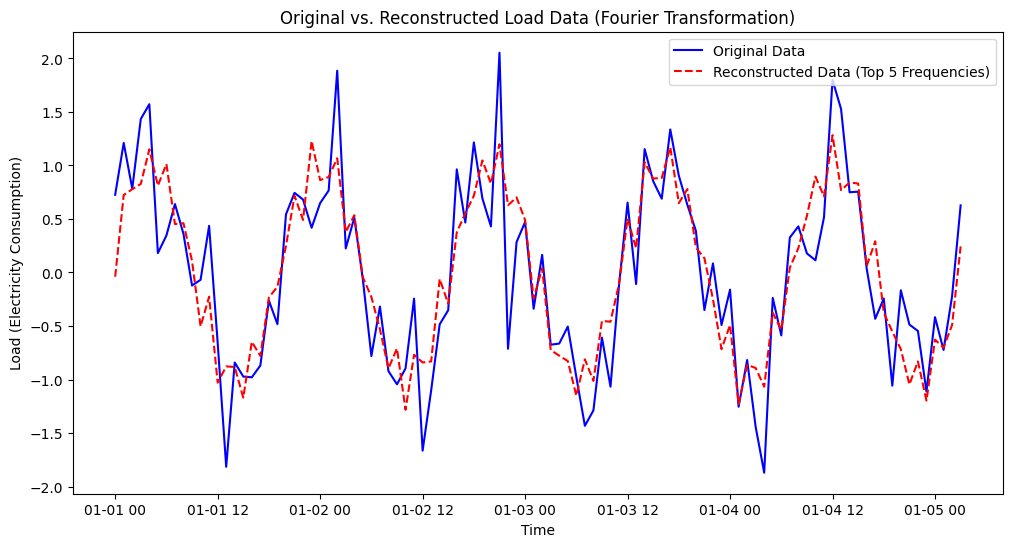

In [17]:
utils = Utils()

# Example synthetic data: Let's create a time-series of 100 hourly points
df = pd.DataFrame({
    'timestamp': pd.date_range(start='1/1/2018', periods=100, freq='H'),
    'out.electricity.total.energy_consumption': np.sin(np.linspace(0, 10 * np.pi, 100)) + np.random.normal(0, 0.5, 100)
})

df = utils.convert_column_to_datetime(df, 'timestamp')

# Display the loaded data (before Fourier transformation)
print("Input Data:")
print(df.head())

# Now apply the Fourier transform to the load data
df_fourier = utils.load_to_fourier(df, column='out.electricity.total.energy_consumption', top_n=5)

print("\nReconstructed Data with Fourier Transformation:")
print(df_fourier[['out.electricity.total.energy_consumption', 'reconstructed_out.electricity.total.energy_consumption']].head())

plt.figure(figsize=(12, 6))

# Plot original data
plt.plot(df_fourier.index, df_fourier['out.electricity.total.energy_consumption'], label='Original Data', color='blue')

# Plot reconstructed data
plt.plot(df_fourier.index, df_fourier['reconstructed_out.electricity.total.energy_consumption'], label='Reconstructed Data (Top 5 Frequencies)', color='red', linestyle='--')

# Add title and labels
plt.title('Original vs. Reconstructed Load Data (Fourier Transformation)')
plt.xlabel('Time')
plt.ylabel('Load (Electricity Consumption)')
plt.legend()